# BUILDING A DEFUALT DETECTION MODEL

---



## Table of Contents
1. Problem Description (Brief Write Up)
2. Exploratory Data Analysis (EDA)
3. Data Pre-processing
4. Model Selection
5. Evaluation
6. Discussion and Possible Improvements

## 1. Problem Description

The goal of this project is to predict a binary target feature (default or not) valued 0 (= not default) or 1 (= default). This project will cover the entire data science pipeline, from data analysis to model evaluation. We will be trying several models to predict default status, and choosing the most appropriate one at the end. 

The data set we will be working on contains payment information of 30,000 credit card holders obtained from a bank in Taiwan, and each data sample is described by 23 feature attributes and the binary target feature (default or not).

The 23 explanatory attributes and their explanations (from the data provider) are as follows:

### X1 - X5: Indivual attributes of customer

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 

X2: Gender (1 = male; 2 = female). 

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

X4: Marital status (1 = married; 2 = single; 3 = others). 

X5: Age (year). 

### X6 - X11: Repayment history from April to Septemeber 2005
The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months, . . . 8 = payment delay for eight months; 9 = payment delay for nine months and above.


X6 = the repayment status in September, 2005

X7 = the repayment status in August, 2005

X8 = the repayment status in July, 2005

X9 = the repayment status in June, 2005

X10 = the repayment status in May, 2005

X11 = the repayment status in April, 2005. 

### X12 - X17: Amount of bill statement (NT dollar) from April to September 2005

X12 = amount of bill statement in September, 2005; 

X13 = amount of bill statement in August, 2005

. . .

X17 = amount of bill statement in April, 2005. 

### X18 - X23: Amount of previous payment (NT dollar)
X18 = amount paid in September, 2005

X19 = amount paid in August, 2005

. . .

X23 = amount paid in April, 2005. 


## EDA

In this section we will explore the data set, its shape and its features to get an idea of the data.

### Importing packages and the dataset

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

In [308]:
url = 'https://raw.githubusercontent.com/reonho/bt2101disrudy/master/card.csv'
df = pd.read_csv(url,  header = 1, index_col = 0)
# Dataset is now stored in a Pandas Dataframe

In [309]:
#rename the target variable to "Y" for convenience
df["Y"] = df["default payment next month"] 
df = df.drop("default payment next month", axis = 1)
df0 = df #backup of df
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [310]:
size = df.shape
print("Data has {} Columns and {} Rows".format(size[1], size[0]))

Data has 24 Columns and 30000 Rows


In [311]:
#check for null values
df.isnull().any().sum() 

0

From the above analyses, we observe that:
1. The data indeed has 30000 rows and 24 columns
2. There are no null values

We will now explore the features more in depth.

### Exploring the features

**1) Exploring target attribute:**


defaults : 22.12 %
non defaults : 77.88000000000001 %


Text(0, 0.5, 'Frequency')

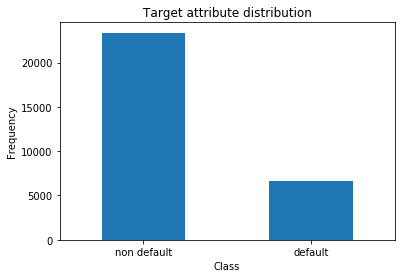

In [312]:
All = df.shape[0]
default = df[df['Y'] == 1]
nondefault = df[df['Y'] == 0]

x = len(default)/All
y = len(nondefault)/All

print('defaults :',x*100,'%')
print('non defaults :',y*100,'%')

# plotting target attribute against frequency
labels = ['non default','default']
classes = pd.value_counts(df['Y'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Target attribute distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

**2) Exploring categorical attributes**

Categorical attributes are:
- Sex
- Education
- Marriage

In [313]:
print(df["SEX"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["EDUCATION"].value_counts().apply(lambda r: r/All*100))
print("--------------------------------------------------------")
print(df["MARRIAGE"].value_counts().apply(lambda r: r/All*100))

2    60.373333
1    39.626667
Name: SEX, dtype: float64
--------------------------------------------------------
2    46.766667
1    35.283333
3    16.390000
5     0.933333
4     0.410000
6     0.170000
0     0.046667
Name: EDUCATION, dtype: float64
--------------------------------------------------------
2    53.213333
1    45.530000
3     1.076667
0     0.180000
Name: MARRIAGE, dtype: float64


**Findings**

- Categorical variable SEX does not seem to have any missing/extra groups, and it is separated into Male = 1 and Female = 2
- Categorical variable MARRIAGE seems to have unknown group = 0, which could be assumed to be missing data, with other groups being Married = 1, Single = 2, Others = 3
- Categorical variable EDUCATION seems to have unknown group = 0,5,6, with other groups being graduate school = 1, university = 2, high school = 3, others = 4 

In [314]:
#proportion of target attribute (for reference)
print('Total target attributes:')
print('non defaults :',y*100,'%')
print('defaults :',x*100,'%')
print("--------------------------------------------------------")
#analysing default payment with Sex
sex_target = pd.crosstab(df["Y"], df["SEX"]).apply(lambda r: r/r.sum()*100).rename(columns = {1: "Male", 2: "Female"}, index = {0: "non defaults", 1: "defaults"})
print(sex_target)
print("--------------------------------------------------------")
#analysing default payment with education
education_target = pd.crosstab(df["Y"], df["EDUCATION"]).apply(lambda r: r/r.sum()*100).rename(index = {0: "non defaults", 1: "defaults"})
print(education_target)
print("--------------------------------------------------------")
#analysing default payment with marriage
marriage_target = pd.crosstab(df["Y"], df["MARRIAGE"]).apply(lambda r: r/r.sum()*100).rename(columns = {0: "unknown",1: "married", 2: "single", 3: "others"},index = {0: "non defaults", 1: "defaults"})
print(marriage_target)

Total target attributes:
non defaults : 77.88000000000001 %
defaults : 22.12 %
--------------------------------------------------------
SEX                Male     Female
Y                                 
non defaults  75.832773  79.223719
defaults      24.167227  20.776281
--------------------------------------------------------
EDUCATION         0          1          2          3          4          5  \
Y                                                                            
non defaults  100.0  80.765234  76.265146  74.842384  94.308943  93.571429   
defaults        0.0  19.234766  23.734854  25.157616   5.691057   6.428571   

EDUCATION             6  
Y                        
non defaults  84.313725  
defaults      15.686275  
--------------------------------------------------------
MARRIAGE        unknown    married     single     others
Y                                                       
non defaults  90.740741  76.528296  79.071661  73.993808
defaults       9.25925

In [315]:
# we would like to conduct a chi square test of independence using the contingency tables above
import scipy.stats as sp_stat

def sigf(p, confidence):
  return str(p) + " *** [Significant at the " + str(int(confidence*100)) + "% Level]" if p < 1-confidence else p

#print the p values for the test statistic of each chi-sq test
print("SEX:", sigf(sp_stat.chi2_contingency(sex_target)[1], 0.95))
print("EDUCATION:", sigf(sp_stat.chi2_contingency(education_target)[1],0.95))
print("MARRIAGE:", sigf(sp_stat.chi2_contingency(marriage_target)[1],0.95))

SEX: 0.6854422910010494
EDUCATION: 1.0276815835411287e-08 *** [Significant at the 95% Level]
MARRIAGE: 0.016161318279331434 *** [Significant at the 95% Level]


**Conclusion**

From the analyses above we conclude that

1. The categorical data is noisy - EDUCATION and MARRIAGE contains unexplained/anomalous data.
2. Categorical attributes EDUCATION and MARRIAGE are likely to be associated with the target variable
3. SEX is not expected to be an important factor in our models as it appears to be statistically insignificant
 

**3) Analysis of Numerical Attributes**

The numerical attributes are:
   




In [316]:
#printing numerical attributes
pd.DataFrame(df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis = 1).columns)

,0
0,LIMIT_BAL
1,AGE
2,PAY_0
3,PAY_2
4,PAY_3
5,PAY_4
6,PAY_5
7,PAY_6
8,BILL_AMT1
9,BILL_AMT2


In [317]:
df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis=1).describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


**Analysis of PAY_0 to PAY_6**

We observe that the minimum value of PAY_0 to PAY_6 is -2. The dataset's author has explained these factors (PAY_0 to PAY_6) as the number of months of payment delay, that is, 1= payment delay of one month; 2= payment delay of two months and so on. 

However, the presence of -2, -1 in these columns indicates that
1. There is anomalous data, OR 
2. The numbers do not strictly correspond to the number of months of payment delay. 

This means we must conduct some data transformation.

According to **(link)**, the numeric value in these attributes shows the past history of a credit card holder, where -2 means: No consumption of credit card, -1 means that holder paid the full balance, and 0 means the use of revolving credit.



**Relationships with Target**

To find out the relationships between the features, we calculate the absolute value of R with the target for all attributes. (R = Correlation Coefficient)


In [318]:
#absolute correlation coefficient
pd.DataFrame(df.drop(['SEX', 'EDUCATION', 'MARRIAGE','Y'], axis=1).apply(lambda x: x.corr(df.Y) if x.corr(df.Y) > 0 else -x.corr(df.Y)).sort_values(ascending = False))

,0
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
LIMIT_BAL,0.153520
PAY_AMT1,0.072929
PAY_AMT2,0.058579
PAY_AMT4,0.056827


We observe that the "repayment status" attributes are the most highly correlated with the target variable and we would expect them to be more significant in predicting credit default. In fact the later the status (pay_0 is later than pay_6), the more correlated it is.

Now that we have an idea of the features, we will move on to feature selection and data preparation.

## Data Preprocessing

In this part, we will conduct some feature selection (for models that do not have embedded feature selection). Additionally, it was previously mentioned that our data had a bit of noise, so we will also clean up the data to allow us to correctly apply ML models. 

### Filter method for feature selection
The filter method for feature selection entails selecting relevant attributes before moving on to learning phase

In [15]:
#importing libraries
from sklearn.datasets import load_boston
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

We compute the Pearson Correlation between each input attribute and the target attribute. Those with correlations below a threshold are excluded from the learning phase.


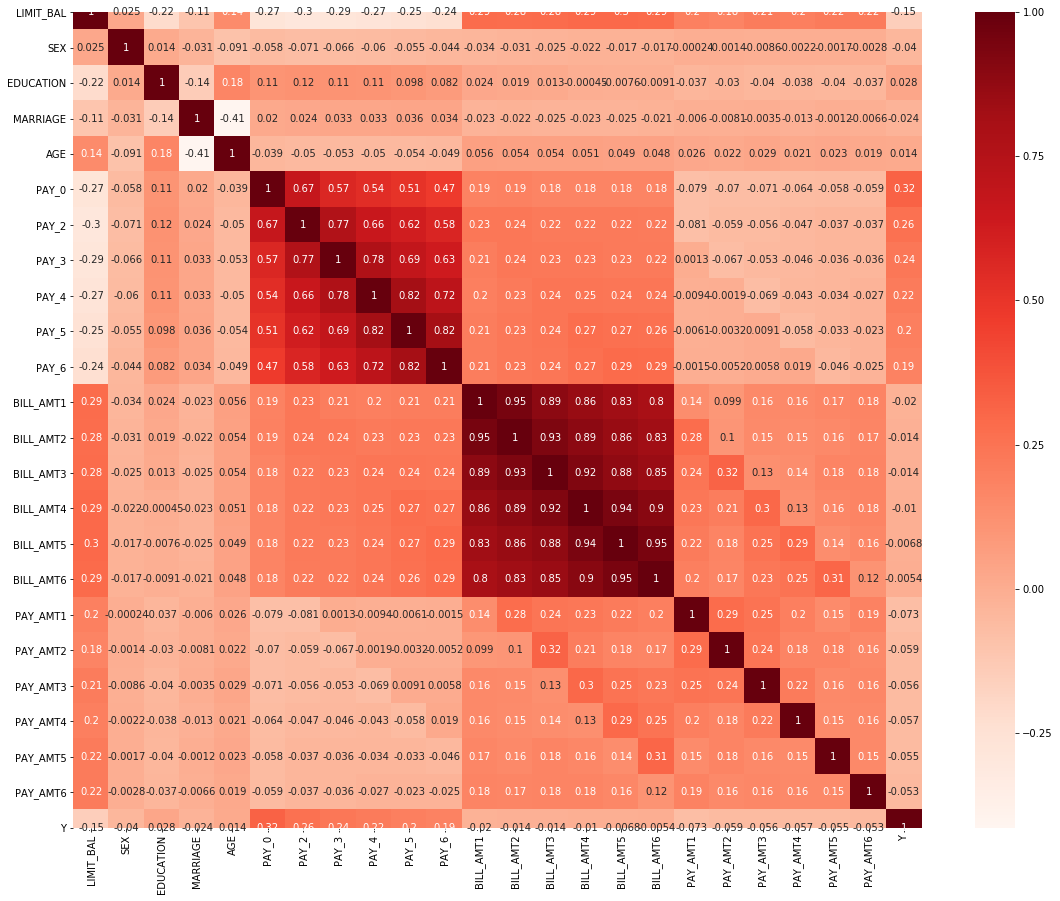

In [319]:
#Using Pearson Correlation
plt.figure(figsize= (19, 15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Removing Noise
#### Inconsistency
First, we found in our data exploration that education has unknown groups 0, 5 and 6. These will be replaced with Education = Others, which has value 4

In [320]:
df['EDUCATION'].replace([0,5,6], 4, regex=True, inplace=True)
df["EDUCATION"].unique()

array([2, 1, 3, 4], dtype=int64)

In [321]:
df['MARRIAGE'].replace([0], 3, regex=True, inplace=True)
df["MARRIAGE"].unique()

array([1, 2, 3], dtype=int64)

#### Outliers
Next, we would like to remove outliers from the continuous variables. Assuming that all the data points are normally distributed, we will consider a point an outlier if it falls outside the 99% interval of a distribution. (Critical value = 2.58) 

In [322]:
from scipy import stats
#we are only concerned with the ordinal data
o = pd.DataFrame(df.drop(['EDUCATION', 'MARRIAGE', "SEX"], axis=1))
#rows where the absolute z score of all columns are less than 2.58 (critical value)
rows = (np.abs(stats.zscore(o)) < 2.58).all(axis=1)
df = df[rows]
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,...,25128.00000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000,25128.000000
mean,152888.092964,1.613937,1.844675,1.563873,35.024554,-0.085840,-0.225127,-0.260148,-0.313913,-0.358445,...,31879.61712,29394.608286,28196.281280,3606.968641,3696.252467,3201.249522,2850.484479,2840.468959,2882.267869,0.212472
std,116895.631153,0.486855,0.740839,0.521725,8.782188,1.020072,1.092299,1.094282,1.056713,1.025571,...,40923.95966,38977.042600,38392.329148,5182.549076,6111.658249,5406.757131,4899.719901,4810.352492,5317.958689,0.409065
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-50616.00000,-53007.000000,-94625.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1623.00000,1178.000000,814.000000,996.500000,785.000000,390.000000,225.000000,165.000000,0.000000,0.000000
50%,130000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16941.50000,15029.500000,13313.000000,2000.000000,2000.000000,1600.000000,1265.500000,1300.000000,1200.000000,0.000000
75%,210000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,45781.75000,40615.500000,38585.750000,4404.250000,4136.250000,3638.250000,3224.500000,3290.500000,3179.250000,0.000000
max,500000.000000,2.000000,4.000000,3.000000,59.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,208931.00000,196698.000000,192499.000000,48329.000000,65280.000000,50551.000000,45171.000000,44197.000000,51000.000000,1.000000


### Feature Scaling
The models used subsequently may have difficulty converging before the maximum number of iterations allowed
is reached if the data is not normalized. Additionaly, Multi-layer Perceptron is sensitive to feature scaling, so we will use StandardScaler for standardization. We only want to scale the numerical factors.

In [323]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = df.drop(["Y", "SEX", "MARRIAGE", "EDUCATION"], axis =1).columns
df[cols] = scaler.fit_transform(df[cols])
df

C:\Users\reonh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\reonh\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,-1.136832,2,2,1,-1.255356,2.044837,2.037145,-0.676121,-0.649279,-1.600657,...,-0.779012,-0.754167,-0.734439,-0.695997,-0.492062,-0.592095,-0.581776,-0.590503,-0.541998,1
2,-0.281351,2,2,2,-1.027618,-0.896189,2.037145,0.237739,0.297071,0.349514,...,-0.699057,-0.665523,-0.649499,-0.695997,-0.441174,-0.407137,-0.377679,-0.590503,-0.165907,1
3,-0.537996,2,2,2,-0.116665,0.084153,0.206108,0.237739,0.297071,0.349514,...,-0.428819,-0.370651,-0.329429,-0.403085,-0.359362,-0.407137,-0.377679,-0.382613,0.398231,0
4,-0.880188,2,2,1,0.224942,0.084153,0.206108,0.237739,0.297071,0.349514,...,-0.087130,-0.011176,0.035183,-0.310079,-0.274440,-0.370146,-0.357269,-0.368269,-0.353953,0
5,-0.880188,1,2,1,2.502324,-0.896189,0.206108,-0.676121,0.297071,0.349514,...,-0.267321,-0.262945,-0.236127,-0.310079,5.397128,1.257479,1.255100,-0.447267,-0.414315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29993,-1.222380,1,3,1,0.908157,0.084153,0.206108,0.237739,-1.595628,-1.600657,...,-0.779012,-0.754167,-0.734439,-0.310079,-0.604799,-0.592095,-0.581776,-0.590503,-0.541998,0
29995,-0.623544,1,2,2,-0.116665,2.044837,2.037145,2.065457,2.189771,2.299686,...,1.115246,1.365251,1.379514,0.654716,-0.032112,-0.592095,0.846905,-0.590503,0.210185,1
29996,0.574130,1,3,1,0.452680,0.084153,0.206108,0.237739,0.297071,0.349514,...,1.371458,0.047270,-0.318202,0.944155,2.667700,0.333247,0.040108,0.448943,-0.353953,0


### One-Hot Encoding

In some models, categorical variables which are encoded numerically will be erroneously treated as ordinal data. To understand why this is a problem, consider the "Education" column for our dataset.

A logistic regression model, for example, will assume that the difference in odds of default between education = 1 and education = 2 is the same as the difference between education = 2 and 3. This is wrong because the difference in odds between a graduate degree and university (1 and 2) is likely to be different from that between univeristy education and high school education (2 and 3).

One hot encoding will allow our models to treat these columns explicitly as categorical features.

The following categorical columns will be one-hot encoded

1. EDUCATION
2. MARRIAGE

In [324]:
from sklearn.preprocessing import OneHotEncoder

In [325]:
onenc = OneHotEncoder(categories='auto')

In [326]:
onehot = pd.DataFrame(onenc.fit_transform(df[['EDUCATION', 'MARRIAGE']]).toarray())
onehot.columns= names = ["GRAD","UNI","HS","OTHER-EDU","MARRIED","SINGLE","OTHER_MS"]
#drop one of each category to prevent dummy variable trap
onehot = onehot.drop(["OTHER-EDU", "OTHER_MS"], axis = 1)
onehot.head()

,GRAD,UNI,HS,MARRIED,SINGLE
0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0


In [327]:
df1 = df.drop(['EDUCATION', 'MARRIAGE'], axis = 1)
df1 = pd.concat([df1.reset_index(drop=True), onehot], axis=1)
df1.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,GRAD,UNI,HS,MARRIED,SINGLE
0,-1.136832,2,-1.255356,2.044837,2.037145,-0.676121,-0.649279,-1.600657,-1.528474,-0.734773,...,-0.592095,-0.581776,-0.590503,-0.541998,1,0.0,1.0,0.0,1.0,0.0
1,-0.281351,2,-1.027618,-0.896189,2.037145,0.237739,0.297071,0.349514,2.253746,-0.760267,...,-0.407137,-0.377679,-0.590503,-0.165907,1,0.0,1.0,0.0,0.0,1.0
2,-0.537996,2,-0.116665,0.084153,0.206108,0.237739,0.297071,0.349514,0.362636,-0.210263,...,-0.407137,-0.377679,-0.382613,0.398231,0,0.0,1.0,0.0,0.0,1.0
3,-0.880188,2,0.224942,0.084153,0.206108,0.237739,0.297071,0.349514,0.362636,0.157367,...,-0.370146,-0.357269,-0.368269,-0.353953,0,0.0,1.0,0.0,1.0,0.0
4,-0.880188,1,2.502324,-0.896189,0.206108,-0.676121,0.297071,0.349514,0.362636,-0.637351,...,1.257479,1.255100,-0.447267,-0.414315,0,0.0,1.0,0.0,1.0,0.0


In [328]:
#check for perfect collinearity
corr = df1.corr()
for i in range(len(corr)):
    corr.iloc[i,i] = 0
#corr[corr == 1] = 0
corr[corr.eq(1).any(1)]

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y,GRAD,UNI,HS,MARRIED,SINGLE


## Model Selection

In this part, we will fit machine learning models learnt in BT2101 to this classification problem, and pick the model that can produce the best results.

We will be attempting to fit the following models:


- Decision Tree 
- Logistic Regression
- Support Vector Machine
- Neural Network


In [329]:
from sklearn.metrics import *
from sklearn.model_selection import *

In [330]:
#using holdout sampling for train test split
ft = df1.drop("Y", axis = 1)
target = df1["Y"]
X_train,X_test,y_train,y_test = train_test_split(ft,target,test_size=0.20)
#make the results reproducible (according to instructions)
np.random.seed(123) 

To make things easier, we define a get_roc function that will plot an ROC curve for all the models we evaluate, and a confusion matrix function.

In [332]:
def get_roc(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    
    #find- best threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold: " + str(optimal_threshold))
    
    plt.show()
    
    return auc(fpr, tpr)

In [333]:
def confusion(y_test, predictions, name):
    conf = pd.crosstab(y_test,predictions, rownames=['Actual'], colnames=['Predicted'])
    print("Of " + str(conf[0][1] + conf[1][1]) + " Defaulters, the " + name + " identified " + str(conf[1][1])) 
    return conf

In [334]:
evaluation = pd.DataFrame(columns=['Model', 'Recall-1', 'AUROC'])

### Evaluation 
We will select the model based on the model evaluation. The key metrics we will compute are:

1. Accuracy
2. Recall
3. AUROC

Because of the nature of a default detection problem, we would like to prioritise **recall** for defaults. 
This means we will place more importance in correctly identifying a defaulter than avoiding misclassifying a non-defaulter. (Assumming that the bank loses more money when lending to a defaulter than not lending to a non-defaulter)

However, simply predicting every data point as a defaulter will give us 100% recall. We have to also consider accuracy and AUROC to get a better idea of how our model performs.


###  Decision Trees

#### Theory:
The decision tree algorithm aims to recursively split the data points in the training set until the data points are completely separated or well separated. At each iteration, the tree splits the datasets by the feature(s) that give the maximum reduction in heterogeneity, which is calculated by a heterogeneity index.

Below is a binary decision tree that has been split for a few iterations.

![image.png](https://elf11.github.io/images/decisionTree.png)

Since the target for this project is binary (fraud = yes or no) we will be building a binary decision tree, using the the GINI Index as the Heterogeneity index. The GINI is given by:

![image.png](https://miro.medium.com/max/664/1*otdoiyIwxJI-UV0ukkyutw.png)

The GINI index measures how heterogenous a single node is (0 being completely homogenous and 1 being heterogenous). For each possible split, we will calculate the *weighted sum* of the GINI indices of the child nodes, and choose the split that results in the maximum information gain. i.e. reduction in the weighted sum of the GINI Index.

#### Training
We will now construct a simple decision tree using the GINI index.

In [335]:
from sklearn.tree import DecisionTreeClassifier

In [336]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [337]:
print(classification_report(y_train, tree.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15866
           1       1.00      1.00      1.00      4236

    accuracy                           1.00     20102
   macro avg       1.00      1.00      1.00     20102
weighted avg       1.00      1.00      1.00     20102



The training set accuracy is 1, which means the datapoints are completely separated by the decision tree. We evaluate on the test set below.

In [338]:
confusion(y_test, tree.predict(X_test), "Decision Tree (GINI)")

Of 1103 Defaulters, the Decision Tree (GINI) identified 444


Predicted,0,1
Actual,,
0,3227,696
1,659,444


Optimal Threshold: 0.5


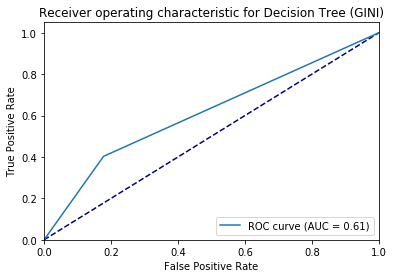

In [339]:
auroc = get_roc(tree, y_test, X_test, "Decision Tree (GINI)")

In [340]:
print(classification_report(y_test, tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3923
           1       0.39      0.40      0.40      1103

    accuracy                           0.73      5026
   macro avg       0.61      0.61      0.61      5026
weighted avg       0.73      0.73      0.73      5026



In [341]:
evaluation.loc[0] = (["Decision Tree" , 
                      classification_report(y_test, tree.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])
evaluation

,Model,Recall-1,AUROC
0,Decision Tree,0.402539,0.612706


### Random Forest Classifier

#### Theory
Random Forest is an ensemble method for the decision tree algorithm. It works by randomly choosing different features and data points to train multiple trees (that is, to form a forest) - and the resulting prediction is decided by the votes from all the trees. 

Decision Trees are prone to overfitting on the training data, which reduces the performance on the test set. Random Forest mitigates this by training multiple trees. Random Forest is a form of bagging ensemble where the trees are trained concurrently. 

#### Training
To keep things consistent, our Random Forest classifier will also use the GINI Coefficient.



In [342]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(n_estimators=300)

In [343]:
randf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [344]:
print(classification_report(y_train, randf.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15866
           1       1.00      1.00      1.00      4236

    accuracy                           1.00     20102
   macro avg       1.00      1.00      1.00     20102
weighted avg       1.00      1.00      1.00     20102



The training set has also been 100% correctly classified by the random forest model. Evaluating with the test set:

In [345]:
confusion(y_test, randf.predict(X_test), "Decision Tree (Random Forest)")

Of 1103 Defaulters, the Decision Tree (Random Forest) identified 355


Predicted,0,1
Actual,,
0,3726,197
1,748,355


Optimal Threshold: 0.3233333333333333


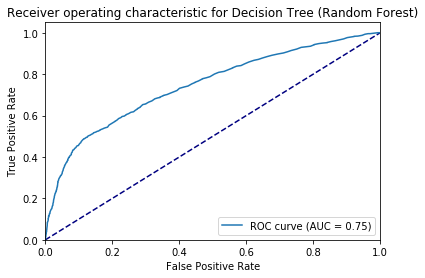

In [346]:
auroc = get_roc(randf, y_test, X_test, "Decision Tree (Random Forest)")

In [347]:
print(classification_report(y_test, randf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3923
           1       0.64      0.32      0.43      1103

    accuracy                           0.81      5026
   macro avg       0.74      0.64      0.66      5026
weighted avg       0.79      0.81      0.79      5026



In [348]:
evaluation.loc[1] = (["Random Forest" , 
                      classification_report(y_test, randf.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

The random forest ensemble performs much better than the decision tree alone. The accuracy and AUROC are both superior to the decision tree alone.

### Gradient Boosted Trees Classifier

#### Theory
In this part we train a gradient boosted trees classifier using xgBoost. xgBoost is short for "Extreme Gradient Boosting". It is a boosting ensemble method for decision trees, which means that the trees are trained consecutively, where each new tree added is trained to correct the error from the previous tree.

xgBoost uses the gradient descent algorithm that we learnt in BT2101 at each iteration to maximise the reduction in the error term. (More details? math?)
 
#### Training
For consistency our xgBoost ensemble will use n_estimators = 300 as we have done for the random forest ensemble.

In [349]:
from sklearn.ensemble import GradientBoostingClassifier
xgb = GradientBoostingClassifier(n_estimators=300, max_depth = 4)
xgb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [350]:
print(classification_report(y_train, xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     15866
           1       0.79      0.41      0.54      4236

    accuracy                           0.85     20102
   macro avg       0.83      0.69      0.73     20102
weighted avg       0.85      0.85      0.83     20102



We observe that the xgBoost ensemble did not fully separate the data in the training set. (The default maximum depth is 3, so that might be a factor). Evaluating on the test set,

In [351]:
confusion(y_test, xgb.predict(X_test), "Decision Tree (Gradient Boosted Trees)")

Of 1103 Defaulters, the Decision Tree (Gradient Boosted Trees) identified 348


Predicted,0,1
Actual,,
0,3747,176
1,755,348


Optimal Threshold: 0.2518319662074072


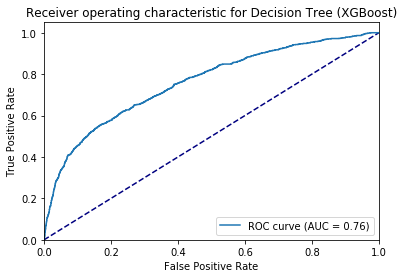

In [352]:
auroc = get_roc(xgb, y_test, X_test, "Decision Tree (XGBoost)")

In [354]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3923
           1       0.66      0.32      0.43      1103

    accuracy                           0.81      5026
   macro avg       0.75      0.64      0.66      5026
weighted avg       0.80      0.81      0.79      5026



In [353]:
evaluation.loc[2] = (["Gradient Boosted" , 
                      classification_report(y_test, xgb.predict(X_test), output_dict = True)["1"]["recall"],
                      auroc])

From the accuracy and AUROC, we observe that the XGBoost performs similarly to the random forest ensemble. It has a slight bump in AUROC at 0.76, but the accuracy is the same.

In [355]:
evaluation

,Model,Recall-1,AUROC
0,Decision Tree,0.402539,0.612706
1,Random Forest,0.321850,0.745184
2,Gradient Boosted,0.315503,0.759923


### Logistic Regression

#### Theory
Logistic regression is a regression technnique used to predict binary target variables. It works on the same principles as a linear regression model. 

Our binary target (default vs non-default) can be expressed in terms of odds of defaulting, which is the ratio of the probability of default and probability of non-default. 

In the logistic regression model, we log the odds (log-odds) and equate it to a weighted sum of regressors.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/4a5e86f014eb1f0744e280eb0d68485cb8c0a6c3)

We then find weights for the regressors that best fits the data. Since the binary target (default or not) follows a bernoulli distribution, each data point has the following probability distribution function:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/614e0c64d59f0ff2e926deafcb2de6e502394fac)

We would like to update p for each data point such that the log product (joint probability) of the above function for all data points is maximised. In other words, we are maximising the log-likelihood function.

The logistic regression equation produces a "squashed" curve like the one below. We then pick a cutoff value for the y axis to classify a data point as 0 (non-default) or 1 (default).

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png)


#### Training
We will adopt a top-down approach for training our logistic regression model, i.e. include all regressors first and then remove the most insignificant ones at each iteration to achieve the best fit.

In [356]:
import statsmodels.api as sm

In [357]:
glm = sm.Logit(y_train,X_train).fit()
glm.summary()

Optimization terminated successfully.
         Current function value: 0.458989
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                20102
Model:                          Logit   Df Residuals:                    20076
Method:                           MLE   Df Model:                           25
Date:                Sun, 17 Nov 2019   Pseudo R-squ.:                  0.1086
Time:                        00:11:31   Log-Likelihood:                -9226.6
converged:                       True   LL-Null:                       -10351.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIMIT_BAL     -0.0501      0.023     -2.163      0.031      -0.096      -0.005
SEX           -0.2034      0.036     -5.658      0.000      -0.274      -0.133
AGE            0.0058      0.021      0.275      0.784      -0.036       0.047
PAY_0          0.6079      0.023     26.717      0.000       0.563       0.652
PAY_2          0.1169      0.028      4.147      0.000       0.062       0.172
PAY_3          0.0689      0.032      2.166      0.030       0.007       0.131
PAY_4          0.0423      0.034      1.251      0.211      -0.024       0.109
PAY_5          0.0525      0.036      1.476      0.140      -0.017       0.122
PAY_6         -0.0221      0.031     -0.720      0.471      -0.082       0.038
BILL_AMT1     -0.3993      0.090     -4.457      0.000      -0.575      -0.224
BILL_AMT2     -0.0629      0.125     -0.502      0.616      -0.309       0.183
BILL_AMT3      0.2031      0.115      1.766      0.077      -0.022       0.428
BILL_AMT4      0.0388      0.104      0.373      0.709      -0.165       0.242
BILL_AMT5     -0.1033      0.125     -0.829      0.407      -0.347       0.141
BILL_AMT6      0.1786      0.099      1.797      0.072      -0.016       0.373
PAY_AMT1      -0.1105      0.030     -3.734      0.000      -0.168      -0.053
PAY_AMT2      -0.1873      0.033     -5.617      0.000      -0.253      -0.122
PAY_AMT3      -0.1044      0.030     -3.498      0.000      -0.163      -0.046
PAY_AMT4      -0.0471      0.028     -1.706      0.088      -0.101       0.007
PAY_AMT5      -0.0955      0.028     -3.424      0.001      -0.150      -0.041
PAY_AMT6      -0.0309      0.025     -1.254      0.210      -0.079       0.017
GRAD          -0.2667      0.112     -2.386      0.017      -0.486      -0.048
UNI           -0.3574      0.110     -3.259      0.001      -0.572      -0.143
HS            -0.4106      0.115     -3.572      0.000      -0.636      -0.185
MARRIED       -0.7734      0.108     -7.176      0.000      -0.985      -0.562
SINGLE        -0.9653      0.108     -8.923      0.000      -1.177      -0.753
==============================================================================
"""

In [358]:
print(classification_report(y_train,list(glm.predict(X_train)>0.5)))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     15866
           1       0.68      0.21      0.32      4236

    accuracy                           0.81     20102
   macro avg       0.75      0.59      0.60     20102
weighted avg       0.79      0.81      0.77     20102



In [359]:
print(classification_report(y_test,list(glm.predict(X_test)>0.5)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3923
           1       0.71      0.20      0.31      1103

    accuracy                           0.81      5026
   macro avg       0.76      0.59      0.60      5026
weighted avg       0.79      0.81      0.76      5026



The logisitc model with all features performs quite well on both the train and test set with an accuracy of about 0.8. We will now try removing all the insignificant features to see how that affects the model performance.

In [360]:
#remove all insignificant attributes
sig = glm.pvalues[glm.pvalues < 0.05]
glm_2 = sm.Logit(y_train,X_train[sig.index]).fit()
glm_2.summary()

Optimization terminated successfully.
         Current function value: 0.460192
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                20102
Model:                          Logit   Df Residuals:                    20087
Method:                           MLE   Df Model:                           14
Date:                Sun, 17 Nov 2019   Pseudo R-squ.:                  0.1063
Time:                        00:11:31   Log-Likelihood:                -9250.8
converged:                       True   LL-Null:                       -10351.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIMIT_BAL     -0.0611      0.023     -2.715      0.007      -0.105      -0.017
SEX           -0.2033      0.036     -5.700      0.000      -0.273      -0.133
PAY_0          0.6279      0.022     27.909      0.000       0.584       0.672
PAY_2          0.1173      0.028      4.251      0.000       0.063       0.171
PAY_3          0.1328      0.026      5.029      0.000       0.081       0.185
BILL_AMT1     -0.1931      0.024     -8.152      0.000      -0.240      -0.147
PAY_AMT1      -0.1191      0.028     -4.288      0.000      -0.174      -0.065
PAY_AMT2      -0.1476      0.029     -5.038      0.000      -0.205      -0.090
PAY_AMT3      -0.1040      0.027     -3.911      0.000      -0.156      -0.052
PAY_AMT5      -0.0782      0.024     -3.210      0.001      -0.126      -0.030
GRAD          -0.2624      0.111     -2.363      0.018      -0.480      -0.045
UNI           -0.3495      0.109     -3.212      0.001      -0.563      -0.136
HS            -0.4048      0.113     -3.592      0.000      -0.626      -0.184
MARRIED       -0.7654      0.107     -7.135      0.000      -0.976      -0.555
SINGLE        -0.9652      0.107     -9.037      0.000      -1.175      -0.756
==============================================================================
"""

In [361]:
print(classification_report(y_train,list(glm_2.predict(X_train[sig.index])>0.5)))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     15866
           1       0.67      0.20      0.31      4236

    accuracy                           0.81     20102
   macro avg       0.75      0.59      0.60     20102
weighted avg       0.79      0.81      0.77     20102



In [362]:
print(classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.5)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3923
           1       0.70      0.20      0.31      1103

    accuracy                           0.81      5026
   macro avg       0.76      0.59      0.60      5026
weighted avg       0.79      0.81      0.76      5026



Since there is not much change to the model performance on both the train and test set when we reduce the features, we will use the reduced logistic regression model from this point onwards (Principle of Parsimony). 

We now Calculate the AUROC for the train set.

Optimal Threshold: 0.2600122571632845


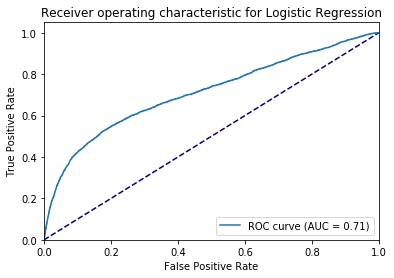

0.7110682677409138

In [363]:
get_roc(glm_2, y_train, X_train[sig.index], "Logistic Regression")

Since the optimal cut off was found to be 0.2697615225249289 using the training data, we will use that as our cut off for our evaluation of the test set.

In [364]:
print(classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.2697615225249289)))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3923
           1       0.45      0.49      0.47      1103

    accuracy                           0.76      5026
   macro avg       0.65      0.66      0.66      5026
weighted avg       0.77      0.76      0.76      5026



Unfortunately, the training accuracy has gone down when we used the optimal cutoff. However, accuracy may be misleading in a dataset like ours where most of the targets are non-defaults. 

The recall here is more important - detecting defaulters is more useful than detecting non-defaulters. With a higher recall, our model with lower cutoff is able to correctly catch more defaulters.


Calculate the confusion matrices for both cut offs to better compare their performance.

In [365]:
confusion(y_test,glm_2.predict(X_test[sig.index])>0.2697615225249289, "Logistic Regression")

Of 1103 Defaulters, the Logistic Regression identified 544


Predicted,False,True
Actual,,
0,3269,654
1,559,544


In [366]:
confusion(y_test,glm_2.predict(X_test[sig.index])>0.50, "Logistic Regression")

Of 1103 Defaulters, the Logistic Regression identified 222


Predicted,False,True
Actual,,
0,3827,96
1,881,222


It is evident that the lower cutoff is better able to detect defualts.

Optimal Threshold: 0.25228751829519586


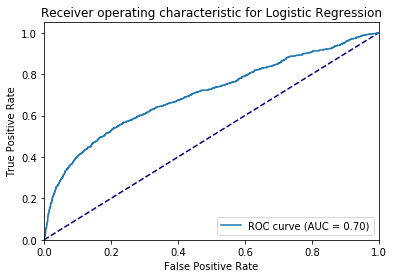

In [367]:
auroc = get_roc(glm_2, y_test, X_test[sig.index], "Logistic Regression")

In [368]:
evaluation.loc[3] = ["Logistic Regression" , classification_report(y_test,list(glm_2.predict(X_test[sig.index])>0.2697615225249289), output_dict = True)["1"]["recall"],auroc]

In [369]:
evaluation

,Model,Recall-1,AUROC
0,Decision Tree,0.402539,0.612706
1,Random Forest,0.321850,0.745184
2,Gradient Boosted,0.315503,0.759923
3,Logistic Regression,0.493200,0.703078


### Support Vector Machine


#### Standardizing attributes to prep for PCA
SVM is computationally expensive for large datasets like ours. Therefore, we would like to reduce the dimensionality of our dataset before training an SVM on it. This can be done through Principle Component Analysis (PCA). The idea would be to reduce the number of features without loss of information.

Using training set to determine parameters of standardization
apply the parameters to standardize all attributes in training and test set

In [ ]:
#Standardising data
from sklearn.preprocessing import StandardScaler
# Standardizing the features
names = X_train.columns
scalar = StandardScaler()
scalar = scalar.fit(X_train)
X_train_standardize = scalar.transform(X_train)
X_train_standardize = pd.DataFrame(data = X_train_standardize, columns = names)
X_test_standardize = scalar.transform(X_test)
X_test_standardize = pd.DataFrame(data = X_test_standardize, columns = names)

In [ ]:
#check if numerical attributes are normailised with mean = 0 and sd = 1
X_train_standardize.describe()

### Perfrom initial PCA for 2 components for visualization
giving 2 pca components, we will visualize the information retained after performing 2 pca components

In [ ]:
#perform pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents =  pca.fit_transform(X_train_standardize)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
#amount of information each principal component holds after projecting the data to a lower dimensional subspace.
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

This shows that the information of principal component 1 retained is 28.4% and principal component 2 retained is 17.8%, both of which is quite low

In [ ]:
#visualizing pca
pca_visualize_df = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pca_visualize_df['Y'] == target
    ax.scatter(pca_visualize_df.loc[indicesToKeep, 'principal component 1']
               , pca_visualize_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

As we can see, there is no clear linear separation for the target attributes for 2 pca components, justifying the above percentages. Nonetherless, we will continue to use PCA by finding the  optimmum number of PC components which retains 90% of information

### Perform PCA to retain 90% of information
perform PCA to reduce components so we can run SVM model

In [ ]:
#setting pca threshold to 90%
pca = PCA(0.9)

In [ ]:
pca.fit(X_train_standardize)

In [ ]:
#get number of components after pca
print('No. of components before pca: {}'.format(len(X_train.columns)))
print('No. of components after pca: {}'.format(pca.n_components_))

As we can see, the number of components is reduced from 23 components to 13 components

In [ ]:
#perform pca on training and test attributes
X_train_pca = pca.transform(X_train_standardize)
X_test_pca = pca.transform(X_test_standardize)

### Apply SVM model
Next, we will used the reduced attributes train set to train our SVM model

First, we train our SVM model without parameter tuning
nor pca reduction

In [ ]:
from sklearn import svm
#train svm model without standardization and no parameter tuning
clf_original = svm.SVC(kernel = 'rbf', probability = True)
clf_original.fit(X_train, y_train)

In [ ]:
#plot roc for svm
get_roc(clf_original, y_test, X_test, "SVM original data RBF kernal")

In [ ]:
#confusion matrix
confusion(y_test,clf_original.predict(X_test), "SVM original data RBF kernal")

Evidently, SVM model fit with no tuning or feature reduction with RBF kernal shows low performance. Now, we will fit SVM model with reduced standardized features and access accuracy

note that the default values of gamma = 1/13 and c= 1

In [ ]:
#train svm model with feature reduction and no parameter tuning
clf_reduced = svm.SVC(kernel = 'rbf', probability = True, gamma = 1/13, C = 1)
clf_reduced.fit(X_train_pca, y_train)

In [ ]:
#plot roc for svm
get_roc(clf_reduced, y_test, X_test_pca, 
        "SVM reduced features no tuning RBF kernal")

In [ ]:
#confusion matrix
confusion(y_test,clf_reduced.predict(X_test_pca), "SVM reduced features no tuning RBF kernal")

As you can see, by reducing features through pca, the AUROC curve improves, suggesting a better prediction model.

We will now try to find best parameters for SVM model

In [ ]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1,10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(X_train_pca, y_train,10)


In [ ]:
#train svm model with feature reduction and cost = 10, gamma = 0.01
clf_reduced_tuned = svm.SVC(kernel = 'rbf', probability = True, C= 10, gamma = 0.01)
clf_reduced_tuned.fit(X_train_pca, y_train)

In [ ]:
get_roc(clf_reduced_tuned, y_test, X_test_pca, 
        "SVM reduced features and tuning RBF kernal")

In [ ]:
#confusion matrix
confusion(y_test,clf_reduced_tuned.predict(X_test_pca), "SVM reduced features and tuning RBF kernal")

From this, we can conclude that fitting SVM model with PCA-reduced features but no parameter tuning is most accurate based on Recall value

Thus, fitting an SVM with PCA-reduced features with default gamma = 1/13 and C = 1 with kernal = 'rbf' is the best model. However, this is only for rbf kernel.

### Neural Networks
We will now use the train and test sets as defined above and attempt to implement a neural network model on the data


In [370]:
from sklearn.neural_network import MLPClassifier

Here we create an instance of our model, with 5 layers of 23 neurons each, identical to that of our training data. 

In [371]:
mlp = MLPClassifier(hidden_layer_sizes=(23,23,23,23,23))

In [372]:
mlp.fit(X_train,y_train)

C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(23, 23, 23, 23, 23), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [373]:
predictions = mlp.predict(X_test)

From here, we produce the confusion matrix and tabulate the accuracy and reliability of the model

In [374]:
confusion(y_test,predictions,"Neural Network (5x23)")

Of 1103 Defaulters, the Neural Network (5x23) identified 285


Predicted,0,1
Actual,,
0,3683,240
1,818,285


In [375]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      3923
           1       0.54      0.26      0.35      1103

    accuracy                           0.79      5026
   macro avg       0.68      0.60      0.61      5026
weighted avg       0.76      0.79      0.76      5026



From this table the results look decent , but the model can still be improved upon. Hence, we will 
double the number of hidden layers to see if there is an improvement in performance.


In [376]:
mlp = MLPClassifier(hidden_layer_sizes=(23,23,23,23,23,23,23,23,23,23))
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))

[[3648  275]
 [ 771  332]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      3923
           1       0.55      0.30      0.39      1103

    accuracy                           0.79      5026
   macro avg       0.69      0.62      0.63      5026
weighted avg       0.76      0.79      0.77      5026



C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [378]:
confusion(y_test,predictions,"Neural Network (10x23)")

Of 1103 Defaulters, the Neural Network (10x23) identified 334


Predicted,0,1
Actual,,
0,3640,283
1,769,334


The avergae accuracy of the model can be said to be similiar to that of the previous one, and is even performing slightly worse, hence we might be overfitting the model. 

In [388]:
#We try to use Keras instead to improve our deep learning performance.

In [394]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=26, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
20102/20102 [==============================] - 2s 93us/step - loss: 0.4588 - accuracy: 0.8085
Epoch 2/10
20102/20102 [==============================] - 2s 86us/step - loss: 0.4385 - accuracy: 0.8201
Epoch 3/10
20102/20102 [==============================] - 2s 83us/step - loss: 0.4348 - accuracy: 0.8222
Epoch 4/10
20102/20102 [==============================] - 2s 83us/step - loss: 0.4330 - accuracy: 0.8233
Epoch 5/10
20102/20102 [==============================] - 2s 80us/step - loss: 0.4317 - accuracy: 0.8224
Epoch 6/10
20102/20102 [==============================] - 2s 83us/step - loss: 0.4301 - accuracy: 0.8234
Epoch 7/10
20102/20102 [==============================] - 2s 85us/step - loss: 0.4288 - accuracy: 0.8231
Epoch 8/10
20102/20102 [==============================] - 2s 82us/step - loss: 0.4273 - accuracy: 0.8241
Epoch 9/10
20102/20102 [==============================] - 2s 82us/step - loss: 0.4269 - accuracy: 0.8246
Epoch 10/10
20102/20102 [==============================

In [415]:
# evaluate the keras model
#recall, accuracy = model.evaluate(df1, target)
#print('Accuracy: %.2f' % (accuracy*100))
#print('Recall: %.2f' % (recall*100))

predictions = list(model.predict(X_test).ravel() > 0.5)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      3923
           1       0.66      0.31      0.42      1103

    accuracy                           0.81      5026
   macro avg       0.74      0.63      0.66      5026
weighted avg       0.79      0.81      0.79      5026

